In [2]:
# Heat transport and temperature
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os

Text(0, 0.5, 'Temperature (°C)')

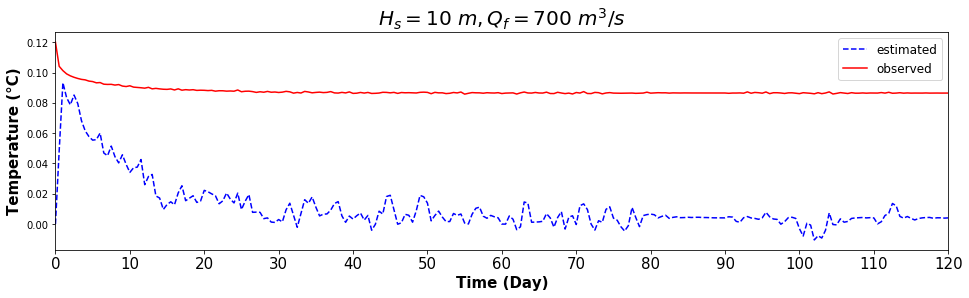

In [23]:
Hs = 10 # Sill depth
Qf = 700 # Freshwater discharge

Cp = 4220  # Specific heat content J/kg/C
rho = 1025 # Density
T0 = 9 # Initial temperature
# Grid areas
Area = np.empty([50, 9])
Area[:10, :] = 100
Area[10:20, :] = 200
Area[20:30, :] = 300
Area[30:40, :] = 800
Area[40:, :] = 1600

# Weight coefficient for temperature calculation
W = np.empty([50,9])
W[:10, :] = 0.5 / 15
W[10:20, :] = 1 / 15
W[20:30, :] = 1.5 / 15
W[30:40, :] = 4 / 15
W[40:, :] = 8 /15


state0 = xr.open_dataset('/Users/weiyangbao/Desktop/State/'+str(format(Hs,'03d'))+'/state_'+str(format(int(Qf/100),'03d'))+'.nc')
state = state0.isel(Y=range(1,10)) # Remove the boundary walls in y direction
Time = state.T.data
pt = state.Temp.data
u0 = state.U.data
u = (u0[:, :, :, 1:] + u0[:, :, :, :-1]) / 2

#pt_mean = pt[:,:,:,1:29].mean(axis=(1,2,3))

Hnet = np.empty(len(Time))
pt_mean = np.empty(len(Time))
for t in range(len(Time)):
    #Vnet[t] = np.sum(u[t,:,:,1]*Area) + np.sum(u[t,:,:,28]*Area)
    pt_t = pt[t,:,:,1:29]
    Hnet[t] = np.sum(u[t,:,:,28]*Area*(pt[t,:,:,28])) - np.sum(u[t,:,:,1]*Area*(pt[t,:,:,1]))
    for xl in range(28):
        pt_mean[t] = (pt_t[:,:,xl] * W).mean()

ut = u.mean(0)
ut[ut != 0] = 1
S = np.empty(ut.shape[2])
for i in range(ut.shape[2]):
    S[i] = np.sum(ut[:,:,i]*Area*200)
Vol = S[1:29].sum() # Domain volume

dt = Time[1] # Time step
pt_pre = np.empty(len(Time))
pt_pre[0] = Hnet[0]*dt/Vol
#pt_pre = np.gradient(Hnet, Time) / (Vol)
for j in range(1,len(Time)):
    pt_pre[j] = Hnet[j-1:j+1].mean()*dt/Vol
#Hnet    
fig, ax = plt.subplots(figsize=(16,4)) 
plt.plot(Time/dt, pt_pre, 'b--', lw=1.5, label='estimated')
plt.plot(Time/dt, pt_mean, 'r-', lw=1.5, label='observed')
plt.legend(loc='best', fontsize=12)
ax.set_xlim([0,240])
ax.set_xticks(np.linspace(0,240,13))
ax.set_xticklabels(np.linspace(0,120,13, dtype = int), size = 15)
plt.title('$H_s = $'+str(Hs)+' $m,Q_f = $'+str(Qf)+' $m^3/s$', size=20)
plt.xlabel("Time (Day)", size=15, weight = 'bold')
plt.ylabel("Temperature (\N{DEGREE SIGN}C)", size=15, weight = 'bold')

In [24]:
fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig.savefig(fig_path + '/EquationH'+str(Hs)+'.png', dpi = 150, bbox_inches='tight')